In [21]:
# ! export OPENBLAS_NUM_THREADS=1

In [38]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette())
from tqdm.notebook import tqdm

from mcmcmd.samplers import *
from mcmcmd.tests import *

# Helper functions

In [40]:
'''
Generate PP plots for beta
'''
def pp_plots_beta(marginal_samples_beta, successive_samples_beta):
    assert marginal_samples_beta.shape[1] == successive_samples_beta.shape[1]
    pp_step_size = 0.001
    p = marginal_samples_beta.shape[1]
    labels = [rf'$\beta_{i}$' for i in range(1,p+1)]

    x_pp = geweke_functions(marginal_samples_beta)
    y_pp = geweke_functions(successive_samples_beta)
    dim_grid = p

    # Check distributions of samples
    x_pp_1 = x_pp[:, :p]
    y_pp_1 = y_pp[:, :p]

    for j in range(dim_grid):
        plt.subplot(dim_grid, dim_grid, j+1)
        plt.tick_params(top=False, bottom=True, left=False, right=False, labelleft=False, labelbottom=True)
        prob_plot(x_pp_1[:, j], y_pp_1[:, j], step=pp_step_size)
        plt.title(labels[j])
        if j==0:
            plt.tick_params(left=True, labelleft=True)
    plt.show()

    # Check distributions of sample cross-products
    x_pp_2 = x_pp[:, p:]
    y_pp_2 = y_pp[:, p:]
    theta2_count = int(p*(p+1)/2)

    ind_plot = 0
    ind_xlabel = 0
    ind_ylabel = 0
    for j in range(dim_grid**2):
        pos_hor = j % dim_grid + 1
        pos_vert = j // dim_grid + 1
        if pos_hor <= pos_vert:
            plt.subplot(dim_grid, dim_grid, j+1)
            plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
            prob_plot(x_pp_2[:, ind_plot], y_pp_2[:, ind_plot], step=pp_step_size)
            ind_plot += 1
        if pos_hor == 1:
            plt.ylabel(labels[ind_ylabel])
            ind_ylabel += 1
            plt.tick_params(left=True, labelleft=True)
        if pos_vert == dim_grid:
            plt.xlabel(labels[ind_xlabel])
            ind_xlabel += 1
            plt.tick_params(bottom=True, labelbottom=True)
    plt.show()

'''
Test a bayes_lasso_sampler
'''
def test(bayes_lasso, num_samples, print_results=True, geweke_thinning=1, use_bonferroni=False):
    marginal_samples = bayes_lasso.sample_mc(num_samples)

    marginal_samples_beta = marginal_samples[:, bayes_lasso.theta_indices]
    marginal_samples_gamma = (marginal_samples_beta!=0).astype('int')
    marginal_samples_k = marginal_samples_gamma.sum(1)

    successive_samples = bayes_lasso.sample_sc(num_samples)
    successive_samples_beta = successive_samples[:, bayes_lasso.theta_indices]
    successive_samples_gamma = (successive_samples_beta!=0).astype('int')
    successive_samples_k = successive_samples_gamma.sum(1)

    backward_samples = bayes_lasso.sample_bc(1e3, burn_in_samples=50)
    backward_samples_beta = backward_samples[:, bayes_lasso.theta_indices]
    backward_samples_gamma = (backward_samples_beta!=0).astype('int')
    backward_samples_k = backward_samples_gamma.sum(1)

    thinned_samples_geweke = onp.arange(0, num_samples, geweke_thinning).astype('int')
    time_start = perf_counter()
    res_geweke = geweke_test(geweke_functions(marginal_samples_beta[thinned_samples_geweke, :]), geweke_functions(successive_samples_beta[thinned_samples_geweke, :]), l=0.04, alpha=0.05, use_bonferroni=use_bonferroni)
    time_end = perf_counter()

    thinned_samples_mmd = onp.arange(0, num_samples, int(num_samples/1000)).astype('int') # thinning for MMD tests
    time_start = perf_counter()
    f_kernel = lambda X, Y: rbf_kernel(X, Y, tau=1)
    res_wild = mmd_wb_test(marginal_samples_beta[thinned_samples_mmd, :], successive_samples_beta[thinned_samples_mmd, :], f_kernel, alpha=0.05)
    time_end = perf_counter()
    time_wild = onp.round(time_end - time_start, 3)
    

    time_start = perf_counter()
    res_backward = mmd_test(marginal_samples_beta[thinned_samples_mmd, :], backward_samples_beta, sg.GaussianKernel(100,1), alpha=0.05)
    time_end = perf_counter()
    time_backward = onp.round(time_end - time_start, 3)
    
    if print_results==True:
      print('Geweke test')
      print(res_geweke)
      print(f'Test time: {onp.round(time_end - time_start, 3)} seconds')

      print('Wild bootstrap MMD test')
      print(res_wild)
      print(f'Test time: {time_wild} seconds')

      print('Backward MMD test')
      print(res_backward)
      print(f'Test time: {time_backward} seconds')

      pp_plots_beta(marginal_samples_beta, successive_samples_beta)
      plt.show()
    
    return {'geweke':res_geweke, 'backward':res_backward, 'wild':res_wild}, {'mc': marginal_samples_beta, 'sc': successive_samples_beta, 'bc': backward_samples_beta}

'''
Test a bayes_lasso_sampler multiple times and save the results
'''
def run_experiment(bayes_lasso, experiment_name, num_trials=20, num_samples=1e5, geweke_thinning=1, use_bonferroni=False):
    num_samples = int(num_samples)

    lst_results = []
    lst_samples = []
    for _ in tqdm(range(num_trials)):
#         time_start = perf_counter()
        res, samples = test(bayes_lasso, num_samples=num_samples, print_results=False, geweke_thinning=geweke_thinning, use_bonferroni=use_bonferroni)

        lst_results.append(res)
        lst_samples.append(samples)

#         time_end = perf_counter()
#         print(f'Iteration time: {onp.round(time_end - time_start, 3)} seconds')

    with open('./results/bayes_lasso/experiment_' + experiment_name + '.pkl', 'wb') as f:
        pickle.dump(lst_results, f)
    with open('./samples/bayes_lasso/experiment_' + experiment_name + '.pkl', 'wb') as f:
        pickle.dump(lst_samples, f)

# Model

Given the multivariate linear regression model

\begin{equation}
  \mathbf{y} = \mathbf{X}\mathbf{\beta} + \mathbf{\epsilon}
\end{equation}

\begin{equation}
  \mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \sigma^{2} \mathbf{I})
\end{equation}

In standard Lasso, we would introduce an L1 penalty to the objective function with a corresponding regularization parameter. Here, we instead promote sparsity by placing a (truncated) Poisson prior on the number $k$ of nonzero coefficients $\beta_{j}$ and drawing these coefficients from a Laplace distribution. Define the parameters $\mathbf{\Theta} = \{\lambda, \sigma, \tau, k, \mathbf{\gamma}, \mathbf{\beta}\}$ such that

\begin{equation}
  p(\mathbf{\Theta}) = p(k|\lambda) p(\mathbf{\gamma}|k) p(\beta_{j} | \tau, \gamma )
\end{equation}

\begin{equation}
  p(k|\lambda) = \frac{\exp{(-\lambda)} \lambda^{k}}{Ck!}, \quad k \in \{1,\ldots, p\}
\end{equation}
\begin{equation}
  p(\mathbf{\gamma}|k) = {p\choose k}^{-1}
\end{equation}

\begin{equation}
  p(\beta_{j} | \tau, \gamma ) = \begin{cases} (2\tau)^{-1}\exp(-\frac{|\beta_{j}|}{\tau}) & j \in \mathbf{\gamma} \\ \delta(\beta_{j}) & \text{otherwise} \end{cases}
\end{equation}

where $C$ is a normalization constant, $\delta$ is the Dirac delta function, and $\mathbf{\gamma}$ is a vector of the nonzero indices of $\mathbf{\beta}$.

The likelihood is given by

\begin{equation}
  p(\mathbf{y} | \sigma, \mathbf{\beta} ) = (2\pi)^{-\frac{n}{2}} \sigma^{-n} \exp{(-\frac{\Vert\mathbf{y}-\mathbf{X}\mathbf{\beta}\Vert^{2}_{2}}{2\sigma^{2}})}
\end{equation}

Here, $\{\lambda, \sigma, \tau\}$ are fixed, but we could place priors on them, e.g., inverse-gamma (TODO?).

Then
\begin{equation}
 p(\mathbf{y}, \mathbf{\Theta} | \mathbf{X} ) \propto \sigma^{-n} \exp{(-\frac{\Vert\mathbf{y}-\mathbf{X}\mathbf{\beta}\Vert^{2}_{2}}{2\sigma^{2}})} \frac{\exp{(-\lambda)} \lambda^{k}}{k!} {p\choose k}^{-1} \prod_{j\in \mathbf{\gamma}} (2\tau)^{-1}\exp(-\frac{|\beta_{j}|}{\tau}) \prod_{k \notin \mathbf{\gamma}} \delta(\beta_{k})
\end{equation}


The code for the `bayes_lasso_sampler` class is in `samplers.py`

Now we will draw the marginal-conditional samples. The `sample_mc` function only returns $\{y_{i}, \mathbf{\beta}_{i}\}$, but it is easy to recover $\{k_{i}, \gamma_{i}\}$ if they are of interest.

In [3]:
n=3; p=3
Lambda=1; tau=1; sigma=1
epsilon_update=2; epsilon_birth=epsilon_update
num_samples = int(1e5)
nproc = 5

In [4]:
bayes_lasso = bayes_lasso_sampler(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso.set_nproc(nproc)
bayes_lasso.drawData() # set X

In [5]:
marginal_samples = bayes_lasso.sample_mc(num_samples)
marginal_samples_beta = marginal_samples[:, bayes_lasso.theta_indices]
# marginal_samples_gamma = (marginal_samples_beta!=0).astype('int')
# marginal_samples_k = marginal_samples_gamma.sum(1)

Each iteration of the reversible-jump MCMC posterior sampler proposes $k' \in \{k-1, k, k+1\}$ uniformly at random, disallowing $k<1$ and $k>p$. Thus, when $k \in \{1,p\}$, there are only two valid proposals, not three. Depending on the $k'$ chosen and the random walk step sizes $\epsilon_{\text{update}}, \epsilon_{\text{birth}}$, one of the following moves are made.

- Update: $k' = k$
  - Choose $j \in \{1, \ldots, k\}$ uniformly at random
  - Propose $\mathbf{\gamma}' = \mathbf{\gamma}, \beta'_{j} = \beta_{j} + \mathcal{N}(0, \epsilon_{\text{update}}), \beta'_{i \neq j} = \beta_{i}$
  - Accept proposal $\mathbf{\Theta}'$ with probability $\min{(\frac{p(\mathbf{y}, \mathbf{\Theta'} | \mathbf{X} )}{p(\mathbf{y}, \mathbf{\Theta} | \mathbf{X} )}, 1)}$

- Birth: $k' = k+1$
  - Choose $j \in \{k+1, \ldots, p\}$ uniformly at random
  - Propose $\mathbf{\gamma}' = \mathbf{\gamma} \cup j$
  - Propose $\beta'_{j} = \mathcal{N}(0, \epsilon_{\text{birth}}), \beta'_{i \neq j} = \beta_{i}$
  - Accept proposal $\mathbf{\Theta}'$ with probability $\min{(\frac{p(\mathbf{y}, \mathbf{\Theta'} | \mathbf{X} )}{p(\mathbf{y}, \mathbf{\Theta} | \mathbf{X} )} \frac{p(\mathbf{\Theta}' \rightarrow \mathbf{\Theta})}{p(\mathbf{\Theta} \rightarrow \mathbf{\Theta}')}, 1)}$
  - The probability of the reverse jump is $p(\mathbf{\Theta}' \rightarrow \mathbf{\Theta}) = \begin{cases}\frac{1}{2}\frac{1}{k'} & k'=p \\ \frac{1}{3} \frac{1}{k'} & 1<k<p \end{cases} $
  - The probability of the forward jump is $p(\mathbf{\Theta} \rightarrow \mathbf{\Theta}') = \begin{cases}\frac{1}{2}\frac{1}{p-k} \mathcal{N}(\beta_{j}'; 0,\epsilon_{\text{birth}}) & k=1 \\ \frac{1}{3} \frac{1}{p-k} \mathcal{N}(\beta_{j}'; 0,\epsilon_{\text{birth}}) & 1<k<p \end{cases} $

- Death: $k' = k-1$
  - Choose $j \in \{1, \ldots, k\}$ uniformly at random
  - Propose $\mathbf{\gamma}' = \mathbf{\gamma} \setminus j$ 
  - Propose $\beta'_{j} = 0, \beta'_{i \neq j} = \beta_{i}$
  - Accept proposal $\mathbf{\Theta}'$ with probability $\min{(\frac{p(\mathbf{y}, \mathbf{\Theta'} | \mathbf{X} )}{p(\mathbf{y}, \mathbf{\Theta} | \mathbf{X} )} \frac{p(\mathbf{\Theta}' \rightarrow \mathbf{\Theta})}{p(\mathbf{\Theta} \rightarrow \mathbf{\Theta}')}, 1)}$
  - The probability of the reverse jump is $p(\mathbf{\Theta}' \rightarrow \mathbf{\Theta}) = \begin{cases}\frac{1}{2}\frac{1}{p-k'} \mathcal{N}(\beta_{j}; 0,\epsilon_{\text{birth}}) & k'=1 \\ \frac{1}{3} \frac{1}{p-k'} \mathcal{N}(\beta_{j}; 0,\epsilon_{\text{birth}}) & 1<k'<p \end{cases} $
  - The probability of the forward jump is $p(\mathbf{\Theta} \rightarrow \mathbf{\Theta}') = \begin{cases}\frac{1}{2}\frac{1}{k} & k=p \\ \frac{1}{3} \frac{1}{k} & 1<k<p \end{cases} $

Now we draw the successive-conditional samples and burned-in backward samples

In [6]:
successive_samples = bayes_lasso.sample_sc(num_samples)
successive_samples_beta = successive_samples[:, bayes_lasso.theta_indices]
# successive_samples_gamma = (successive_samples_beta!=0).astype('int')
# successive_samples_k = successive_samples_gamma.sum(1)

backward_samples = bayes_lasso.sample_bc(1e3, burn_in_samples=100)
backward_samples_beta = backward_samples[:, bayes_lasso.theta_indices]
# # backward_samples_gamma = (backward_samples_beta!=0).astype('int')
# # backward_samples_k = backward_samples_gamma.sum(1)

# Joint Distribution Tests

To check the posterior sampler, we first perform a Geweke test on the first and second empirical moments of the samples.

Notes on the code:
- `geweke_functions(S)` returns $[\mathbf{s}_{1}, \ldots, \mathbf{s}_{p}, \mathbf{s}_{1} \odot \mathbf{s}_{1}, \mathbf{s}_{1} \odot \mathbf{s}_{2}, \ldots, \mathbf{s}_{p} \odot \mathbf{s}_{p} ]$, where $\mathbf{s}_{j}$ is the $j^{\text{th}}$ column of $S$. The column means of the output are the first and second empirical moments of $\mathbf{S}$.
- The argument `l` to `geweke_test` controls the window size used to estimate the successive-conditional standard errors. Specifically, the window size is given by `l * num_samples`. 
- The argument `alpha` to `geweke_test` is the significance level of the tests.

In [7]:
thinned_samples_geweke = onp.arange(0, num_samples, int(num_samples/1e5)).astype('int') # thinning for Geweke tests; will use 1e5 samples.
time_start = perf_counter()
print(geweke_test(geweke_functions(marginal_samples_beta[thinned_samples_geweke, :]), geweke_functions(successive_samples_beta[thinned_samples_geweke, :]), l=0.04, alpha=0.05))
time_end = perf_counter()
print(f'Test time: {onp.round(time_end - time_start, 3)} seconds')

{'result': array([False, False, False, False, False, False, False, False, False]), 'p_value': array([0.81178739, 0.79370884, 0.07974674, 0.63306341, 0.48356379,
       0.16514229, 0.89682855, 0.63244252, 0.96752136]), 'test_statistic': array([ 0.23812081,  0.26149755, -1.75215744,  0.47741953,  0.70058219,
       -1.38798277, -0.1296687 , -0.47829181, -0.04071719]), 'critical_value': 1.959963984540054}
Test time: 13.411 seconds


Next, we perform two different MMD tests. First, the wild bootstrap version:

In [15]:
thinned_samples_mmd = onp.arange(0, num_samples, int(num_samples/1000)).astype('int') # thinning for MMD tests; will use 1000 samples.
time_start = perf_counter()
f_kernel = lambda X, Y: rbf_kernel(X, Y, tau=1)
print(mmd_wb_test(marginal_samples_beta[thinned_samples_mmd, :], successive_samples_beta[thinned_samples_mmd, :], f_kernel, alpha=0.05))
time_end = perf_counter()
print(f'Test time: {onp.round(time_end - time_start, 3)} seconds')

{'result': False, 'p_value': 0.81, 'test_statistic': 1.0208445715462624, 'critical_value': 2.9072556180865066}
Test time: 1.059 seconds


Next, the backward version:

In [ ]:
time_start = perf_counter()
print(mmd_test(marginal_samples_beta[thinned_samples_mmd, :], backward_samples_beta, sg.GaussianKernel(10,1), alpha=0.05))
time_end = perf_counter()
print(f'Test time: {onp.round(time_end - time_start, 3)} seconds')

All three tests fail to reject the null hypothesis that the distributions are the same. To confirm these results visually, we can examine the PP plots of the distributions of the (marginal-conditional and successive-conditional) samples and their cross-products. The closer the points are to the unit line, the better.

In [ ]:
pp_plots_beta(marginal_samples_beta, successive_samples_beta)

Now, let's introduce intentional errors and see if the tests detect them.

In [ ]:
'''
Error 1: forget to include the transition probabilities when calculating the acceptance probabilities for the 'birth' and 'death' moves
'''
class bayes_lasso_sampler_error_1(bayes_lasso_sampler):
    def updateMH(self, j, k_proposal, gamma_proposal, beta_proposal, rng):
      diff_log_joint = self.log_joint(
          beta=beta_proposal, gamma=gamma_proposal, k=k_proposal) - self.log_joint()
      threshold = diff_log_joint

      log_u = onp.log(rng.uniform())
      if log_u <= threshold:
        self._k = k_proposal
        self._gamma = gamma_proposal
        self._beta = beta_proposal
      return log_u, threshold

bayes_lasso_error_1 = bayes_lasso_sampler_error_1(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso_error_1.set_nproc(nproc)
bayes_lasso_error_1.drawData()
res_error_1 = test(bayes_lasso_error_1, num_samples=num_samples)

In [ ]:
'''
Error 2: drop a '+1' in the log-prior calculation
'''
class bayes_lasso_sampler_error_2(bayes_lasso_sampler):
    def log_prior(self, beta=None, gamma=None, k=None):
      if beta is None:
        beta = self._beta
      if gamma is None:
        gamma = self._gamma
      if k is None:
        k = self._k
    #   return - onp.log(comb(self._p, k)) - self._Lambda + k*onp.log(self._Lambda) - loggamma(k+1) + laplace.logpdf(x=beta[gamma, :], scale=self._tau).sum() # correct
      return - onp.log(comb(self._p, k)) - self._Lambda + k*onp.log(self._Lambda) - loggamma(k) + laplace.logpdf(x=beta[gamma, :], scale=self._tau).sum() # error

bayes_lasso_error_2 = bayes_lasso_sampler_error_2(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso_error_2.set_nproc(nproc)
bayes_lasso_error_2.drawData()
res_error_2 = test(bayes_lasso_error_2, num_samples=num_samples)

Both errors are detected by every test!

# Type I/II Error

We will now run `num_trials` instances of each test.

In [ ]:
num_trials = 20
nproc = 5
seed = 10000

In [ ]:
bayes_lasso = bayes_lasso_sampler(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso.set_nproc(nproc)
bayes_lasso.set_seed(seed)
bayes_lasso.drawData()

run_experiment(bayes_lasso, 'default', num_trials)

In [ ]:
bayes_lasso_error_1 = bayes_lasso_sampler_error_1(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso_error_1.set_nproc(nproc)
bayes_lasso_error_1.set_seed(seed)
bayes_lasso_error_1.drawData()

run_experiment(bayes_lasso_error_1, 'error_1', num_trials)

In [ ]:
bayes_lasso = bayes_lasso_sampler_error_2(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso_error_2.set_nproc(nproc)
bayes_lasso_error_2.set_seed(seed)
bayes_lasso_error_2.drawData()

run_experiment(bayes_lasso_error_2, 'error_2', num_trials)

Read results

In [3]:
import pandas as pd
num_trials = 20
df_results = pd.DataFrame(index=onp.arange(0, num_trials*3), columns=('experiment', 'test_type', 'result'))
i=0
for exper in ['default', 'error_1', 'error_2']:
    with open('./results/bayes_lasso/experiment_' + exper + '.pkl', 'rb') as f:
        lst_res = pickle.load(f)
    for res in lst_res:
        df_results.loc[i] = [str(exper), 'geweke', onp.array(res['geweke']['result']).max()] # reject null if at least one test rejects
        df_results.loc[i+1] = [str(exper), 'backward', float(res['backward']['result'])]
        df_results.loc[i+2] = [str(exper), 'wild', float(res['wild']['result'])]
        i+=3
df_results['result'] = pd.to_numeric(df_results['result'])
df_results=df_results.groupby(['experiment', 'test_type']).mean()
df_results

result
experiment test_type        
default    backward     0.00
           geweke       0.55
           wild         0.00
error_1    backward     1.00
           geweke       1.00
           wild         1.00
error_2    backward     0.60
           geweke       0.85
           wild         0.95

The Geweke false positive rate is quite high, and the wild MMD test seems to have the most power.

# Geweke false positive rate

In [ ]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette())

from mcmcmd.samplers import *
from mcmcmd.tests import *

from statsmodels.tsa.stattools import acf

Let's draw 10 successive-conditional chains of 2e6 samples each.

In [ ]:
n=3; p=3
Lambda=1; tau=1; sigma=1
epsilon_update=2; epsilon_birth=epsilon_update

bayes_lasso = bayes_lasso_sampler(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso.set_nproc(1)
bayes_lasso.drawData()

# Draw MC samples
marginal_samples = bayes_lasso.sample_mc(int(1e6))
marginal_samples_beta = marginal_samples[:, bayes_lasso.theta_indices]

# Draw SC samples
bl_var = parallel_sampler(experiment_name='var', sampler = bayes_lasso, num_trials=10, nproc=5, num_samples_mc=0, num_samples_bc=0, num_samples_sc=int(2e6), burn_in_samples_bc=0)
lst_paths=bl_var.run()

We suspect the Geweke false positive rate may be caused by issues with the SC variance estimate. Let's look at the effect of thinning the chains to reduce autocorrelation. Below, we see that the autocorrelation functions fall to approximately zero at a lag of 100.

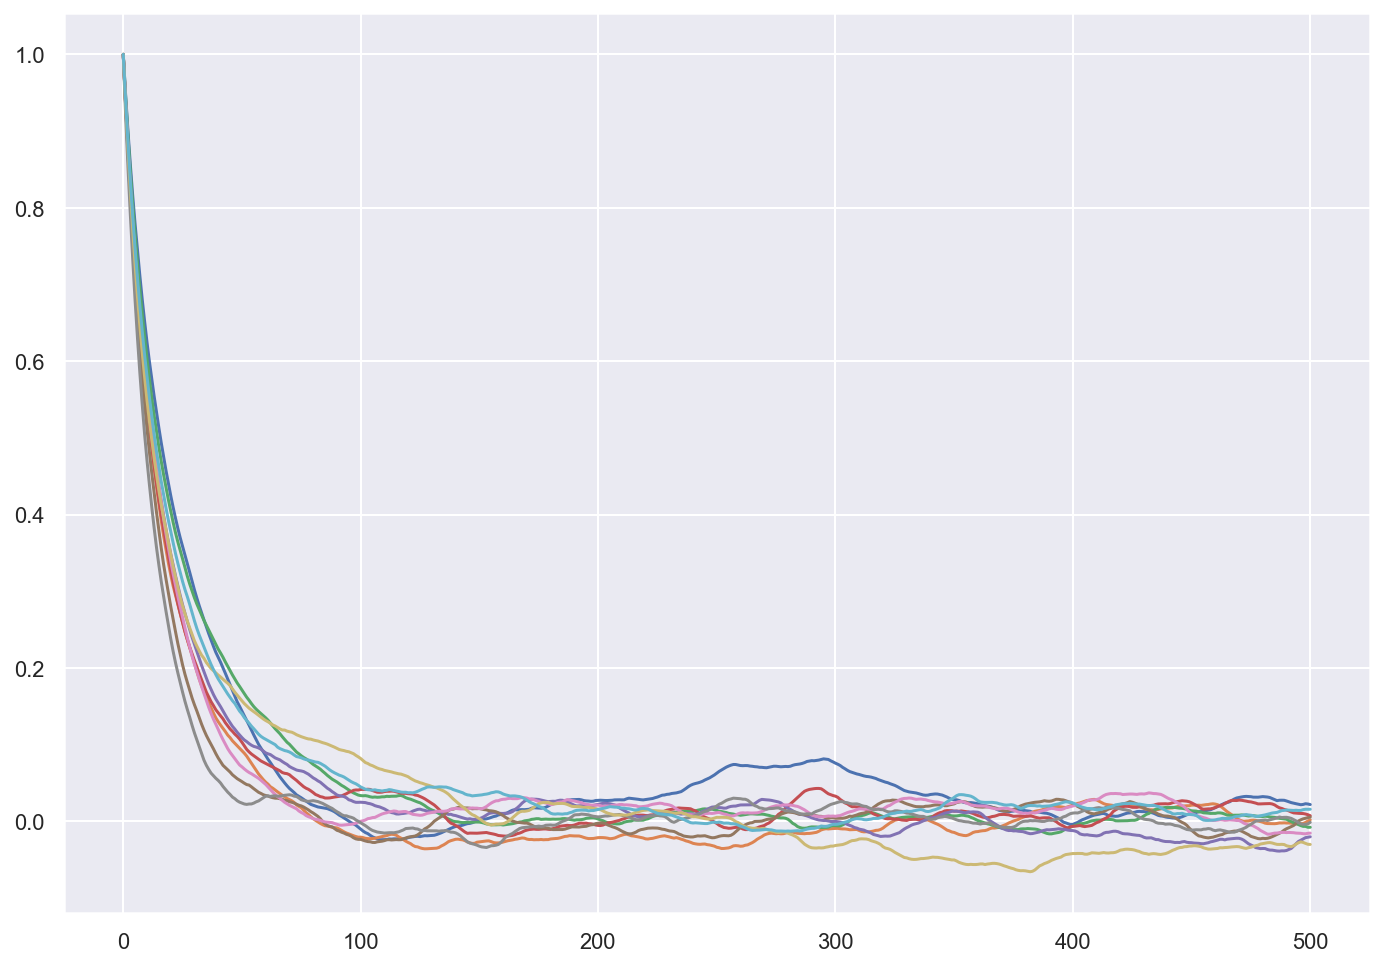

In [64]:
lst_successive = [None] * len(lst_paths) * 2
i=0
for paths in lst_paths:
    for path in paths:
        with(open(path, 'rb')) as f:
            lst_successive[i] = pickle.load(f)['sc'][:, bayes_lasso.theta_indices]
        i += 1
        
for i in range(len(lst_successive)):
    plt.plot(acf(lst_successive[i][:50000, 0].flatten(), nlags=500))

In the Geweke test, we are individually testing $p + \frac{p(p+1)}{2}$ first and second moments, and rejecting the null if any one of the subtests fails. Let's take another view here and treat each subtest as independent. We'll look at how the false positive rate varies by thinning.

In [106]:
import pandas as pd

lst_thinning = [1, 25, 50, 75, 100, 125, 150, 175, 200]
lst_bw = [0, 200, 400, 600, 800]
test_samples = 1e4

df_results = pd.DataFrame(index=onp.arange(0, len(lst_thinning)*len(lst_bw)), columns=('thinning', 'test_samples', 'bw', 'rejection_rate', 'rejection_rate_macro'))
i=0

for bw in lst_bw:
    for thin in lst_thinning:
        rr = 0
        rrm = 0
        for successive_samples_beta in lst_successive:
            thinned_samples_geweke = onp.arange(0, int(thin * test_samples), thin)
            res = geweke_test(geweke_functions(marginal_samples_beta[:, :]), geweke_functions(successive_samples_beta[thinned_samples_geweke, :]), l=bw/test_samples, alpha=0.05)['result']
            rr += res.mean()
            rrm += res.max()
        rr /= len(lst_successive)
        rrm /= len(lst_successive)
        df_results.loc[i] = [thin, test_samples, bw, rr, rrm]
        i += 1

    df_results = df_results.apply(pd.to_numeric, 1)

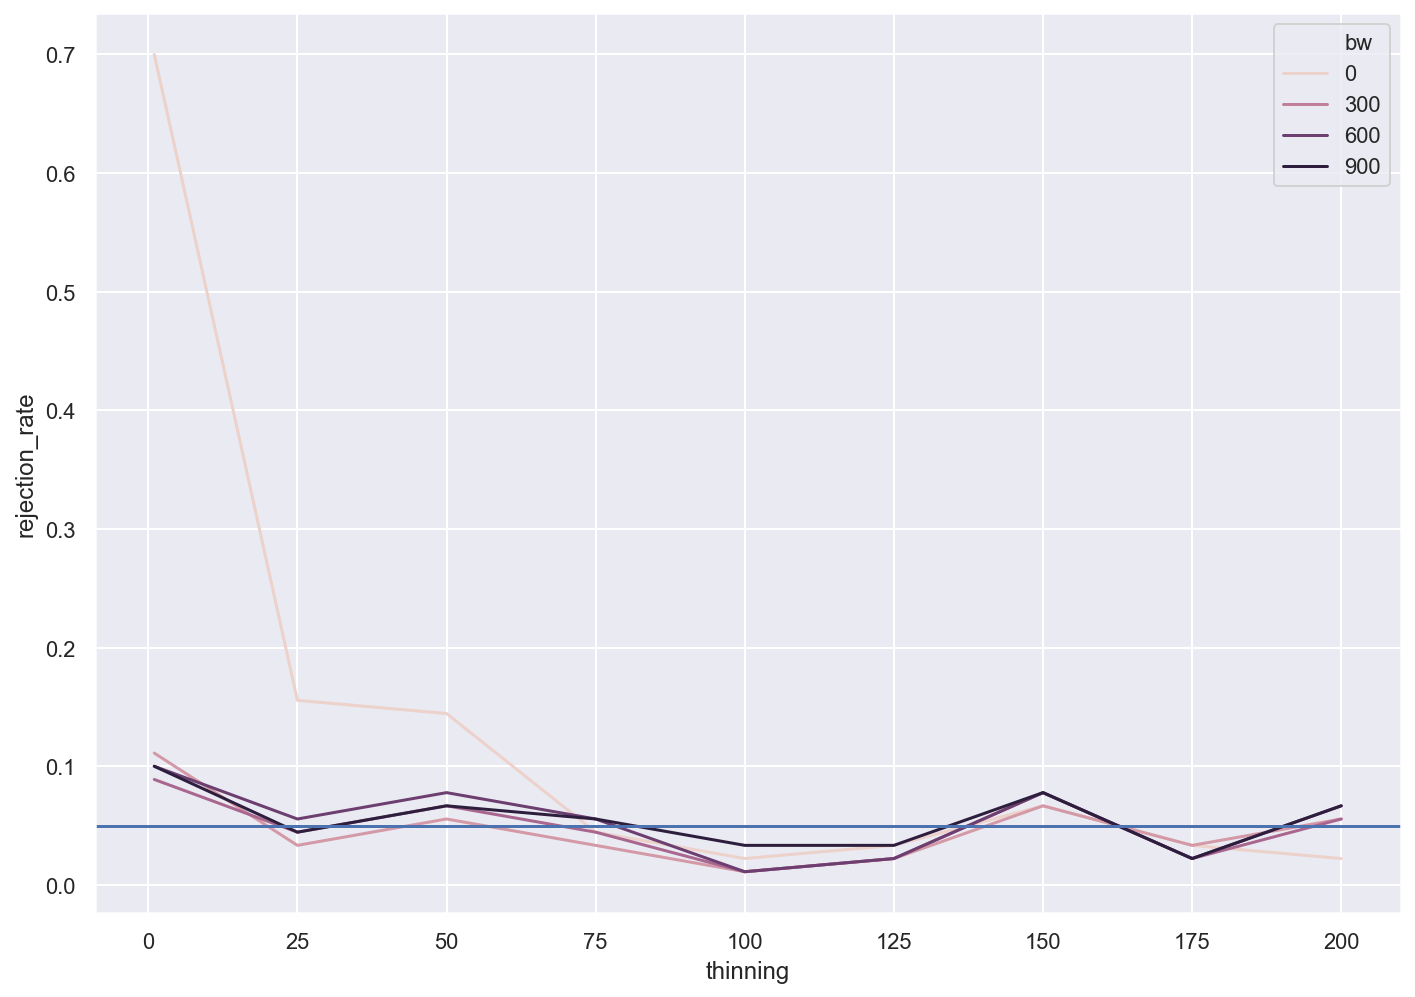

In [107]:
rr_plot = sns.lineplot(data=df_results, x='thinning', y='rejection_rate', hue='bw')
rr_plot.axhline(0.05)

Holding the test sample size constant, each of the curves corresponds to a different window width. 

Some observations:

- As we increase the amount of thinning from left to right, we can see that the rejection rate using the naive variance estimate converges to the other curves. This makes sense; as we thin, the serial correlation falls until we have approximately independent samples.

- The overall rejection rate using the window estimates is around 5%! This implies that the primary driver of the elevated false positive rate is not the variance estimate, but rather multiple testing.
    - The variance estimate may still play a role; it looks like the rejection rate may be slightly elevated without any thinning


Performing the same exercise, but plotting the family rejection rates (rejecting the null that the MC and SC samples are from the same distribution if at least one subtest fails) shows that as we observed in the previous experiment, the false positive rate is elevated

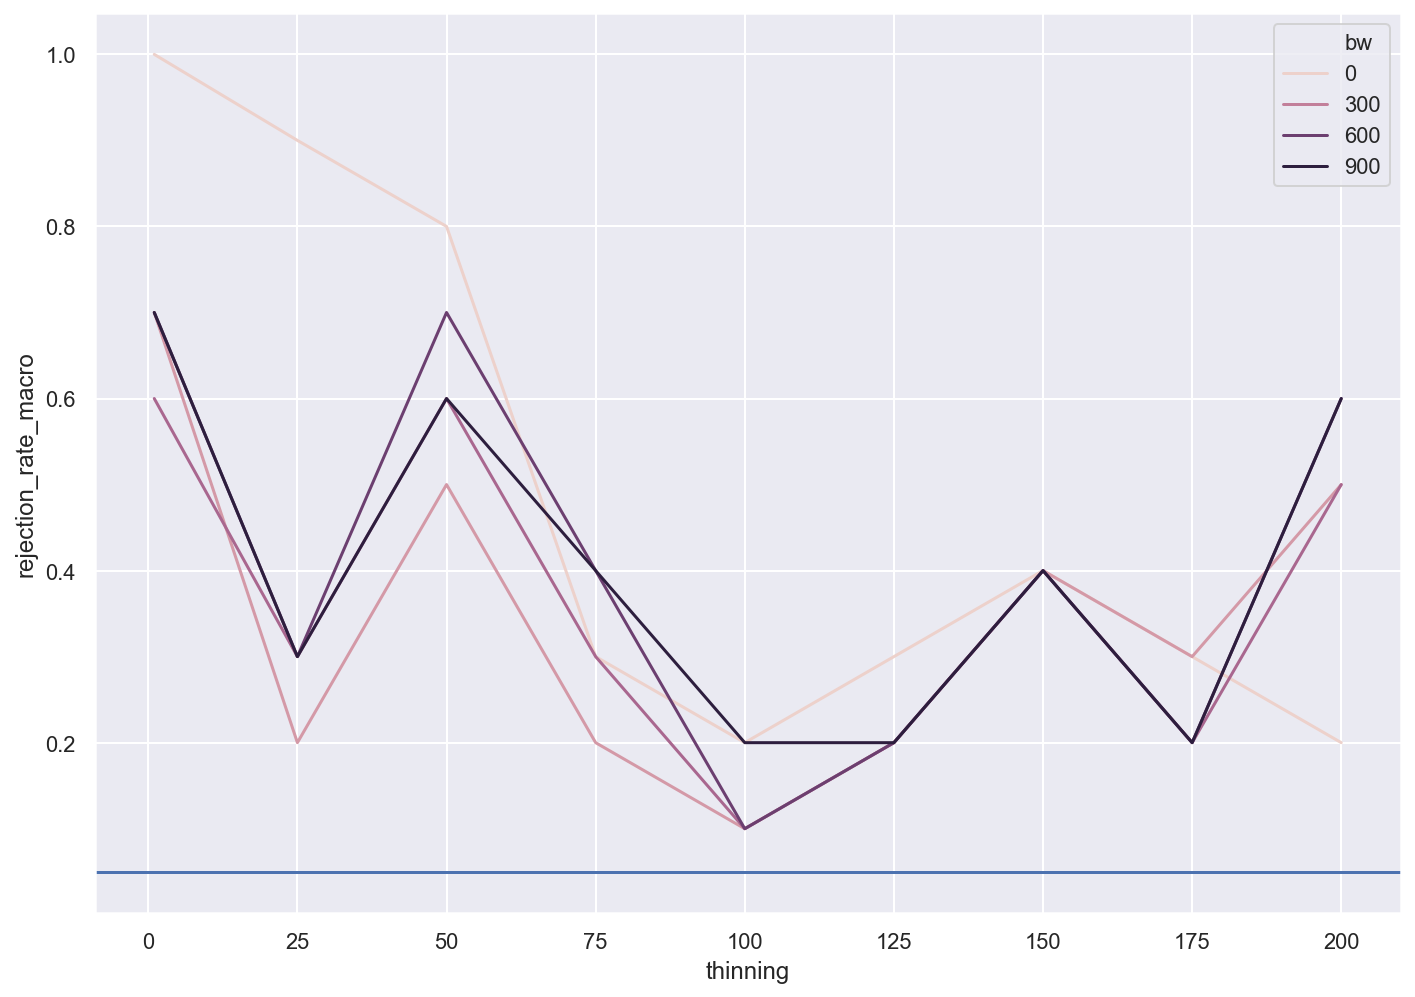

In [108]:
rr_plot = sns.lineplot(data=df_results, x='thinning', y='rejection_rate_macro', hue='bw')
rr_plot.axhline(0.05)


Now let's retroactively look at what happens when we apply just the Bonferroni correction to our results from the previous section. The false positive rate falls, but is still higher than we would like. Moreover, the test power also falls drastically.

In [5]:
import pandas as pd
num_trials = 20
df_results = pd.DataFrame(index=onp.arange(0, num_trials*4), columns=('experiment', 'test_type', 'result'))
i=0
for exper in ['default', 'error_1', 'error_2']:
    with open('./results/bayes_lasso/experiment_' + exper + '.pkl', 'rb') as f:
        lst_res = pickle.load(f)
    for res in lst_res:
        # Geweke
        df_results.loc[i] = [str(exper), 'geweke', onp.array(res['geweke']['result']).max()] # reject null if at least one test rejects

        # Geweke with Bonferroni
        p_geweke = res['geweke']['p_value']
        threshold_geweke = 0.05/len(p_geweke)
        result_geweke_bf = p_geweke <= threshold_geweke
        df_results.loc[i+1] = [str(exper), 'geweke_bf', onp.array(result_geweke_bf).max()] # reject null if at least one test rejects
        
        # MMD
        df_results.loc[i+2] = [str(exper), 'backward', float(res['backward']['result'])]
        df_results.loc[i+3] = [str(exper), 'wild', float(res['wild']['result'])]
        i+=4
df_results['result'] = pd.to_numeric(df_results['result'])
df_results=df_results.groupby(['experiment', 'test_type']).mean()
df_results

result
experiment test_type        
default    backward     0.00
           geweke       0.55
           geweke_bf    0.20
           wild         0.00
error_1    backward     1.00
           geweke       1.00
           geweke_bf    0.95
           wild         1.00
error_2    backward     0.60
           geweke       0.85
           geweke_bf    0.45
           wild         0.95

We will now repeat the experiment in the previous section but include thinning as well as the Bonferroni correction, increasing the number of samples drawn to 1e6 and taking every 100th SC sample.

In [43]:
n=3; p=3
Lambda=1; tau=1; sigma=1
epsilon_update=2; epsilon_birth=epsilon_update
nproc = 5
seed=10000

In [44]:
bayes_lasso = bayes_lasso_sampler(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso.set_nproc(nproc)
bayes_lasso.set_seed(seed)
bayes_lasso.drawData()

run_experiment(bayes_lasso, 'default_new', num_trials=20, num_samples=1e6, geweke_thinning=100, use_bonferroni=True)

In [45]:
bayes_lasso_error_1 = bayes_lasso_sampler_error_1(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso_error_1.set_nproc(nproc)
bayes_lasso_error_1.set_seed(seed)
bayes_lasso_error_1.drawData()

run_experiment(bayes_lasso_error_1, 'error_1_new', num_trials=20, num_samples=1e6, geweke_thinning=100, use_bonferroni=True)

In [81]:
bayes_lasso_error_2 = bayes_lasso_sampler_error_2(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso_error_2.set_nproc(nproc)
bayes_lasso_error_2.set_seed(seed)
bayes_lasso_error_2.drawData()

run_experiment(bayes_lasso_error_2, 'error_2_new', num_trials=20, num_samples=1e6, geweke_thinning=100, use_bonferroni=True)

In [82]:
import pandas as pd
num_trials = 20
df_results = pd.DataFrame(index=onp.arange(0, num_trials*3), columns=('experiment', 'test_type', 'result'))
i=0
for exper in ['default_new', 'error_1_new', 'error_2_new']:
    with open('./results/bayes_lasso/experiment_' + exper + '.pkl', 'rb') as f:
        lst_res = pickle.load(f)
    for res in lst_res:
        df_results.loc[i] = [str(exper), 'geweke', onp.array(res['geweke']['result']).max()] # reject null if at least one test rejects
        df_results.loc[i+1] = [str(exper), 'backward', float(res['backward']['result'])]
        df_results.loc[i+2] = [str(exper), 'wild', float(res['wild']['result'])]
        i+=3
df_results['result'] = pd.to_numeric(df_results['result'])
df_results=df_results.groupby(['experiment', 'test_type']).mean()
df_results

result
experiment  test_type        
default_new backward     0.00
            geweke       0.00
            wild         0.05
error_1_new backward     0.95
            geweke       1.00
            wild         1.00
error_2_new backward     0.70
            geweke       1.00
            wild         0.90

In [59]:
# var vs sample size
lst_sample_size = [1e5, 3e5, 5e5, 7e5, 9e5]
lst_var = [None] * len(lst_sample_size)
for exper in ['default_new']:
    with open('./samples/bayes_lasso/experiment_' + exper + '.pkl', 'rb') as f:
        lst_samples = pickle.load(f)
    
    i = 0
    for M in lst_sample_size:
        var = onp.zeros((len(lst_samples), p))
        for j, samples in enumerate(lst_samples):
            var[j] = M * geweke_se2(samples['sc'][:int(M), :], L=1000)
        lst_var[i] = var
        i+=1

Text(0, 0.5, '$\\hat{\\tau}^{2}$, L=1000')

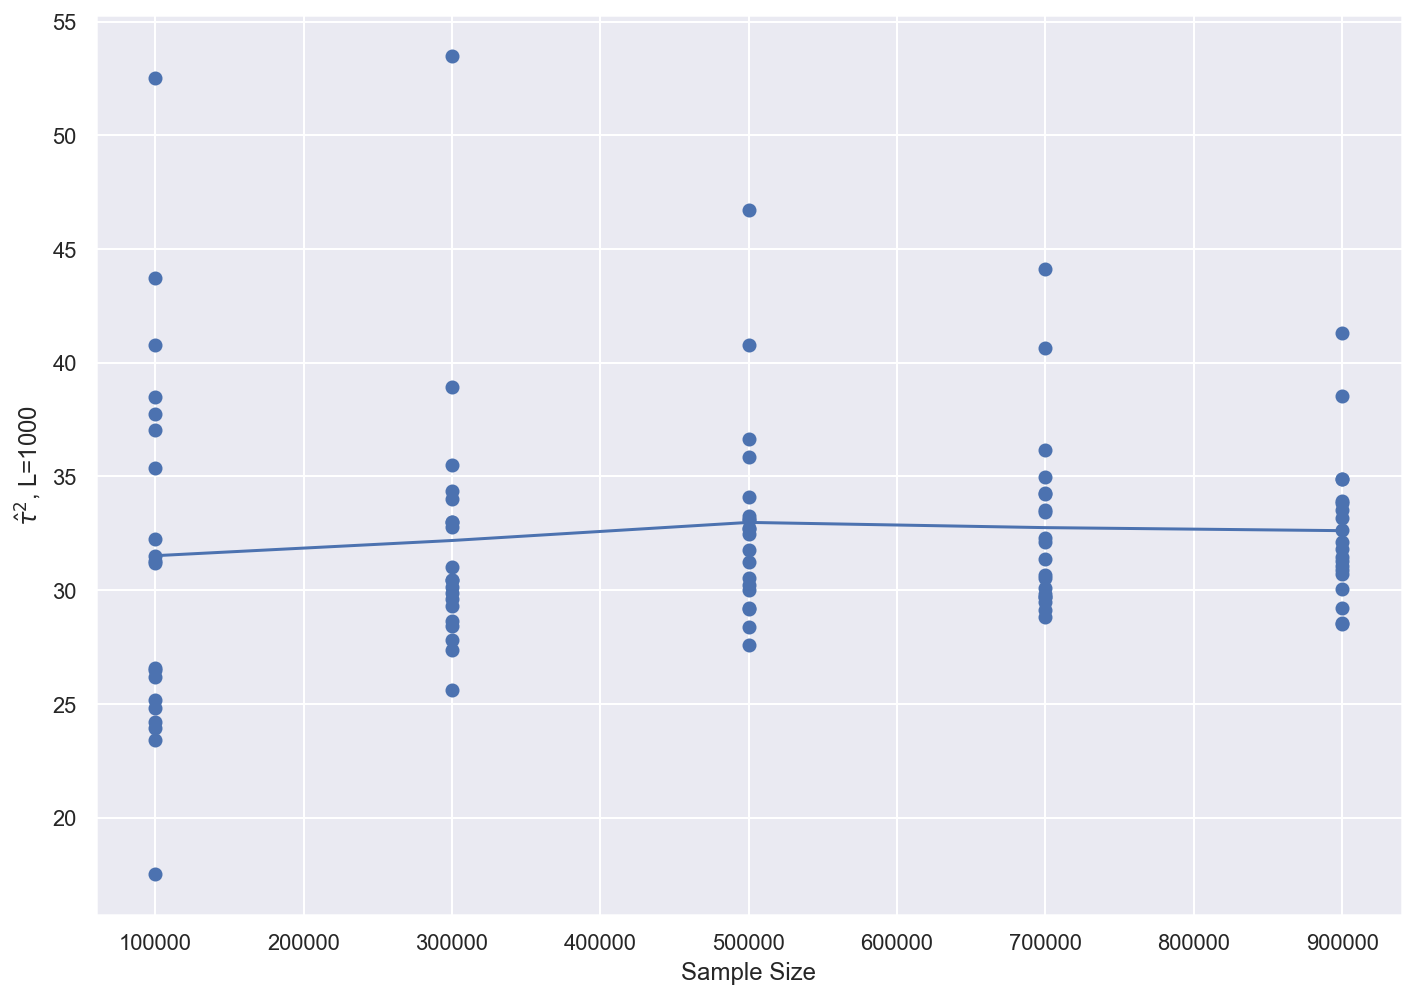

In [85]:
x = onp.repeat(lst_sample_size, 20)
j=0

y = onp.hstack([var[:,j] for var in lst_var])
y_mean = onp.hstack([var[:,j].mean() for var in lst_var])
plt.scatter(x, y)
plt.plot(lst_sample_size, y_mean)
plt.xlabel('Sample Size')
plt.ylabel(r'$\hat{\tau}^{2}$, L=1000')